(transd_partition_mod)=
# Trans-dimensional Modeling

In this section of the tutorial, we treat the number of segments in the piecewise function as unknown.

## Import libraries and define constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from bayesbay.discretization import Voronoi1D
from bayesbay.prior import UniformPrior
from bayesbay.parameterization import Parameterization
from bayesbay import Target, LogLikelihood, BayesianInversion
np.random.seed(30)

In [2]:
X_DATA = np.linspace(0, 10, 100) # 100 data points
NOISE_STD = 5

In [3]:
@np.vectorize
def piecewise_function(x):
    if x <= 1:
        return 1
    elif 1 < x <= 2.5:
        return 20
    elif 2.5 < x <= 3:
        return 0
    elif 3 < x <= 4:
        return -3
    elif 4 < x <= 6:
        return -10
    elif 6 < x <= 6.5:
        return -20
    elif 6.5 < x <= 8:
        return 25
    elif 8 < x <= 9:
        return 0
    elif 9 < x <= 10:
        return 10

## Observed data

In [4]:
d_obs = piecewise_function(X_DATA) + np.random.normal(0, NOISE_STD, X_DATA.size)

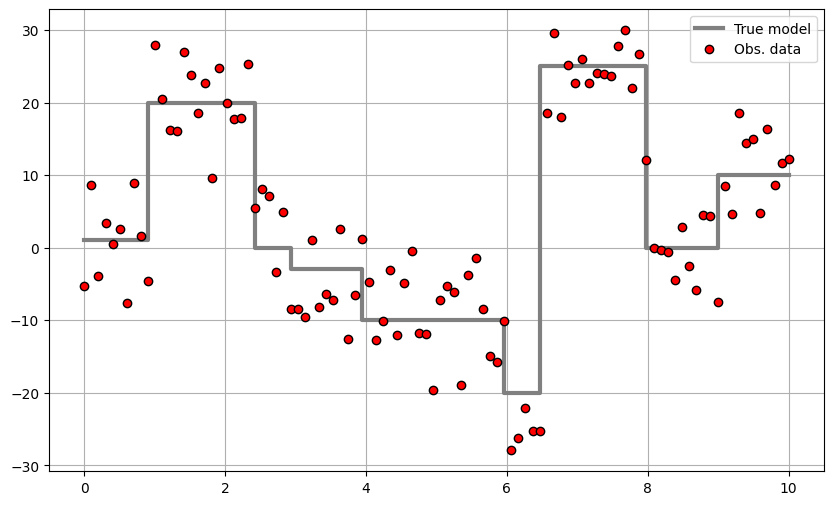

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.step(X_DATA, piecewise_function(X_DATA), 'gray', lw=3, label='True model')
ax.plot(X_DATA, d_obs, 'ro', markeredgecolor='k', label='Obs. data')
ax.legend()
ax.grid()
plt.show()

## Inference parameterization

In [6]:
y = UniformPrior('y', vmin=-35, vmax=35, perturb_std=3.5)
voronoi = Voronoi1D(
    name="voronoi", 
    vmin=0,
    vmax=10,
    perturb_std=0.75,
    n_dimensions=None, 
    n_dimensions_min=2,
    n_dimensions_max=40,
    parameters=[y], 
    birth_from='prior'
)
parameterization = Parameterization(voronoi)

## Forward and Log Likelihood

In [7]:
def fwd_function(state):
    voro = state['voronoi']
    x_nuclei = voro['discretization']
    x_extents = Voronoi1D.compute_cell_extents(x_nuclei)
    x1 = x_extents[0]
    indexes = []
    indexes.extend([0] * np.flatnonzero(X_DATA <= x1).size)
    for i, extent in enumerate(x_extents[1:], 1):
        if extent == 0:
            idx_size = np.flatnonzero(X_DATA > x1).size
        else:
            x2 = x1 + x_extents[i]
            idx_size = np.flatnonzero((X_DATA > x1) & (X_DATA <= x2)).size
            x1 = x2
        indexes.extend([i] * idx_size)
        
    d_pred = voro['y'][indexes]
    return d_pred

In [8]:
target = Target("d_obs", 
                d_obs, 
                std_min=0, 
                std_max=20, 
                std_perturb_std=2)

log_likelihood = LogLikelihood(targets=target, fwd_functions=fwd_function)

## Bayesian Inference

In [9]:
inversion = BayesianInversion(
    parameterization=parameterization, 
    log_likelihood=log_likelihood,
    n_chains=20
)

inversion.run(
    sampler=None, 
    n_iterations=400_000, 
    burnin_iterations=50_000, 
    save_every=40,
    verbose=False
)

In [10]:
for chain in inversion.chains:
    chain.print_statistics()

Chain ID: 0
TEMPERATURE: 1
EXPLORED MODELS: 400000
ACCEPTANCE RATE: 118583/400000 (29.65 %)
PARTIAL ACCEPTANCE RATES:
	BirthPerturbation(voronoi): 3968/56793 (6.99%)
	DeathPerturbation(voronoi): 3963/57442 (6.90%)
	NoisePerturbation(d_obs): 12926/57028 (22.67%)
	ParamPerturbation(voronoi.discretization): 8612/57154 (15.07%)
	ParamPerturbation(voronoi.y): 89114/171583 (51.94%)
Chain ID: 1
TEMPERATURE: 1
EXPLORED MODELS: 400000
ACCEPTANCE RATE: 120724/400000 (30.18 %)
PARTIAL ACCEPTANCE RATES:
	BirthPerturbation(voronoi): 4272/57112 (7.48%)
	DeathPerturbation(voronoi): 4268/56877 (7.50%)
	NoisePerturbation(d_obs): 13128/57034 (23.02%)
	ParamPerturbation(voronoi.discretization): 8906/57257 (15.55%)
	ParamPerturbation(voronoi.y): 90150/171720 (52.50%)
Chain ID: 2
TEMPERATURE: 1
EXPLORED MODELS: 400000
ACCEPTANCE RATE: 120321/400000 (30.08 %)
PARTIAL ACCEPTANCE RATES:
	BirthPerturbation(voronoi): 4424/57297 (7.72%)
	DeathPerturbation(voronoi): 4414/57590 (7.66%)
	NoisePerturbation(d_obs): 1

## Results

In [11]:
results = inversion.get_results(concatenate_chains=True)
percentiles = 10, 90
statistics = Voronoi1D.get_tessellation_statistics(
    results['voronoi.discretization'], 
    results['voronoi.y'], 
    X_DATA, 
    percentiles=percentiles
    )

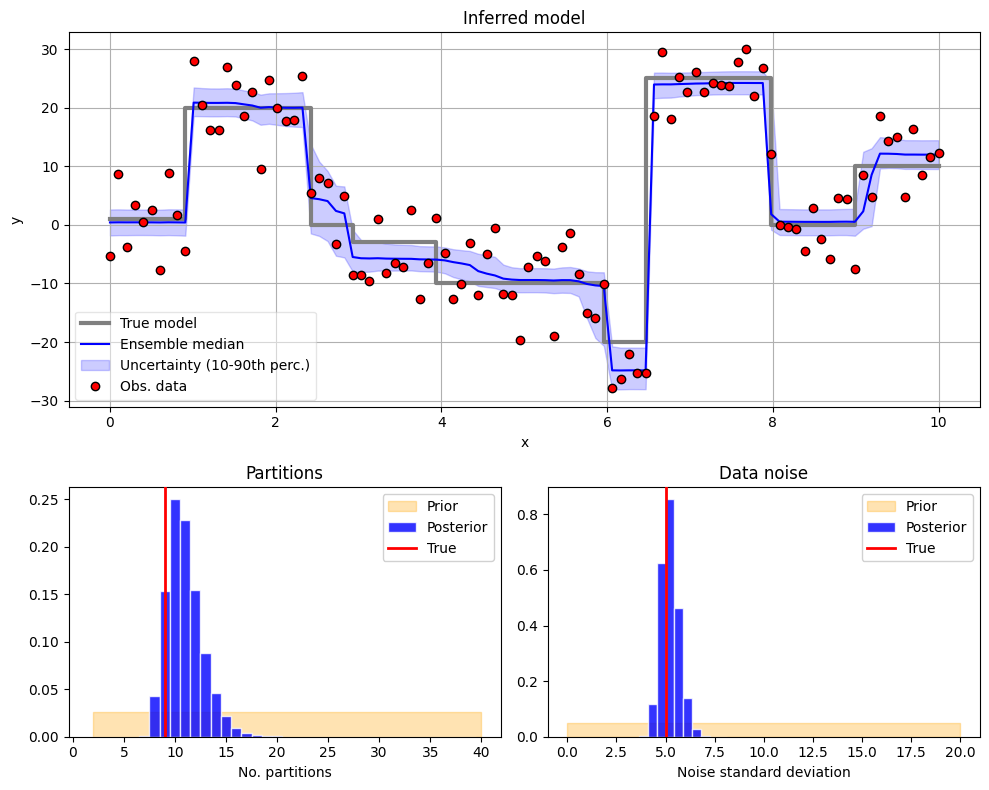

In [14]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1.5, 1])

ax1 = plt.subplot(gs[0, :]) # First row, spans all columns
ax2 = plt.subplot(gs[1, 0]) # Second row, first column
ax3 = plt.subplot(gs[1, 1]) # Second row, second column

ax1.step(X_DATA, piecewise_function(X_DATA), 'gray', lw=3, label='True model')
ax1.plot(X_DATA, statistics['median'], 'b', label='Ensemble median')
ax1.fill_between(X_DATA, 
                *statistics['percentiles'], 
                color='b', 
                alpha=0.2, 
                label='Uncertainty (%s-%sth perc.)'%(percentiles))
ax1.plot(X_DATA, d_obs, 'ro', markeredgecolor='k', label='Obs. data')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend(framealpha=0.5)
ax1.grid()
ax1.set_title('Inferred model')


ndim_min, ndim_max = voronoi._n_dimensions_min, voronoi._n_dimensions_max
ax2.fill_between([ndim_min, ndim_max], 
                 1 / (ndim_max - ndim_min), 
                 alpha=0.3, 
                 color='orange',
                 label='Prior')
ax2.set_xlabel('No. partitions')
ax2.hist(results['voronoi.n_dimensions'], 
         bins=np.arange(ndim_min-0.5, ndim_max+0.5), 
         color='b',
         alpha=0.8, 
         density=True, 
         ec='w', 
         label='Posterior')
ax2.axvline(x=9, color='r', lw=2, alpha=1, label='True', zorder=100)
ax2.legend(framealpha=0)
ax2.set_title('Partitions')

ax2.legend(framealpha=0.9)

ax3.fill_between([target.std_min, target.std_max], 
                 1 / (target.std_max - target.std_min), 
                 alpha=0.3, 
                 color='orange',
                 label='Prior')
ax3.hist(results['d_obs.std'], 
         color='b',
         alpha=0.8, 
         density=True, 
         bins=10, 
         ec='w', 
         label='Posterior')
ax3.axvline(x=NOISE_STD, color='r', lw=2, alpha=1, label='True', zorder=100)
ax3.set_xlabel('Noise standard deviation')
ax3.legend(framealpha=0.9)
ax3.set_title('Data noise')
plt.tight_layout()
plt.show()